---

# <center> ★ AI/ML Project - Image SuperResolution ★
    
#### <center> ***Domain: Computer Vision***

---

<center> <img src="https://raw.githubusercontent.com/Masterx-AI/Project_Image_Super_Resolution/main/Super_Resolution.jpg" style="width: 600px;"/> <center/>

---

### Description:

Most current super-resolution methods rely on a pair of low and high-resolution images to train a network in a supervised manner. However, in real-world scenarios, such pairs are not available. Instead of directly addressing this problem, most tasks employ the popular bicubic down-sampling strategy to generate low-resolution images artificially. Unfortunately, this strategy introduces more artifacts, removing natural incense and other real-world characteristics. Moreover, super-resolution networks trained on such bicubic images suffer many struggles to generalize the natural images.    

Single image super-resolution has fundamental low-level vision problems. The SISR aims to recover the High-Resolution images from a single Low-Resolution image. Various network architecture design and training strategies have continuously improved super-resolution performance, especially when it comes to Peak Single to Noise Ratio (PSNR). 

The model uses Residual-in-Residual block as a basic convolution block instead of a basic residual network or simple convolution trunk to provide a better flow gradient at the microscopic level. In addition to that, the model lacks a  batch normalization layer in the generator to prevent smoothing out the artifacts in the images. This allows the ESRGAN to produce images with a higher approximation of the sharp edges of the image artifacts. 

The ESRGAN uses a Relativistic discriminator to better approximate the probability of an image being real or fake; thus, the intern produces better results. The generator uses a linear combination of Perceptual difference between real and fake images using a pre-trained VGG19 network, Pixel wise absolute difference between real and fake images, and Relativistic average loss between real and fake images function during adversarial training.


### Acknowledgement: 
Google

### Objective:
- Perform Image Super Resolution 

---

In [1]:
# Importing basic libraries

import os
import time 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
os.environ['TFHUB_DOWNLOAD_PROGRESS']='True'

In [18]:
# setting the image and its path

import requests
url = 'https://imgv3.fotor.com/images/slider-image/Blurry-low-quality-female-portrait-picture.jpg'
r = requests.get(url, allow_redirects=True)
open('tiger.jpg', 'wb').write(r.content)

IMAGE_PATH = 'tiger.jpg'
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

## Helper functio to plot and process images

In [19]:
# function to preprocess image so that it can be handled by model
def preprocess_image(image_path):
   '''Loads the image given make it ready for 
      the model
      Args:
        image_path: Path to the image file
   '''
   image = tf.image.decode_image(tf.io.read_file(image_path))
   if image.shape[-1] == 4:
     image = image[...,:-1]
   size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
   image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
   image = tf.cast(image,tf.float32)
   return tf.expand_dims(image,0)

def save_image(image,filename):
  ''' 
   Saves unscaled Tensor Images
   image: 3D image Tensor
   filename: Name of the file to be saved
  '''
  if not isinstance(image, Image.Image):
      image = tf.clip_by_value(image, 0, 255)
      image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save('%s.jpg' % filename)
  print('Saved as %s.jpg' % filename)

In [20]:
preprocess_image(IMAGE_PATH)

<tf.Tensor: shape=(1, 580, 800, 3), dtype=float32, numpy=
array([[[[218., 223., 217.],
         [218., 223., 217.],
         [218., 223., 217.],
         ...,
         [206., 220., 221.],
         [205., 221., 221.],
         [205., 221., 221.]],

        [[218., 223., 217.],
         [218., 223., 217.],
         [218., 223., 217.],
         ...,
         [206., 220., 221.],
         [205., 221., 221.],
         [205., 221., 221.]],

        [[218., 223., 217.],
         [218., 223., 217.],
         [218., 223., 217.],
         ...,
         [206., 220., 221.],
         [205., 221., 221.],
         [205., 221., 221.]],

        ...,

        [[ 66.,  83.,  91.],
         [ 63.,  80.,  88.],
         [ 59.,  76.,  84.],
         ...,
         [153., 164., 186.],
         [153., 164., 186.],
         [153., 164., 186.]],

        [[ 61.,  78.,  86.],
         [ 58.,  75.,  83.],
         [ 54.,  71.,  79.],
         ...,
         [152., 163., 185.],
         [152., 163., 185.],
         

In [21]:
#%matplotlib inline
def plot_image(image,title=''):
  ''' 
  plots the Image tensors
  image: 3D image Tensor
  title: Title for plot
  '''
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis('off')
  plt.title(title)


## Perform super resolution

## load the model

In [22]:
model = hub.load(SAVED_MODEL_PATH)

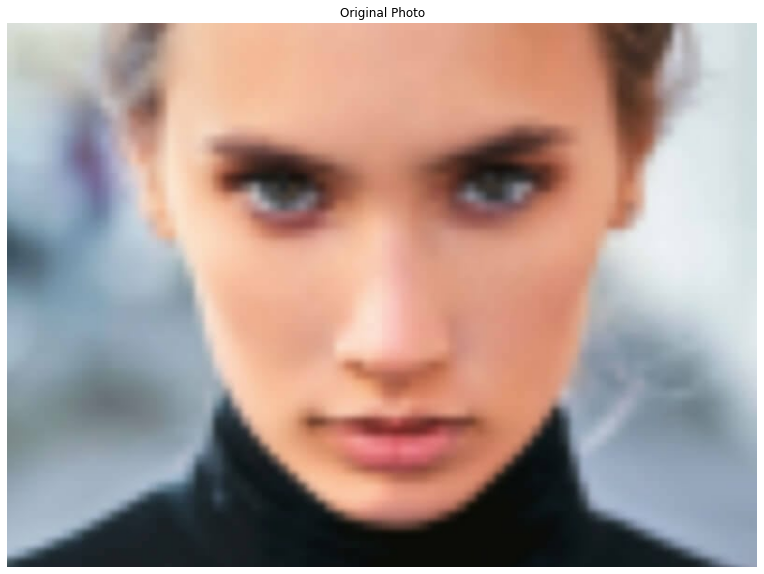

In [23]:
load_image = preprocess_image(IMAGE_PATH)

# plot original image
plot_image(tf.squeeze(load_image),title='Original Photo')

In [24]:
# Start Performing resolution 
start = time.time()
super_image = model(load_image)
super_image = tf.squeeze(super_image)
print('Time taken to complete process: %f'%(time.time() - start))

Time taken to complete process: 45.829698


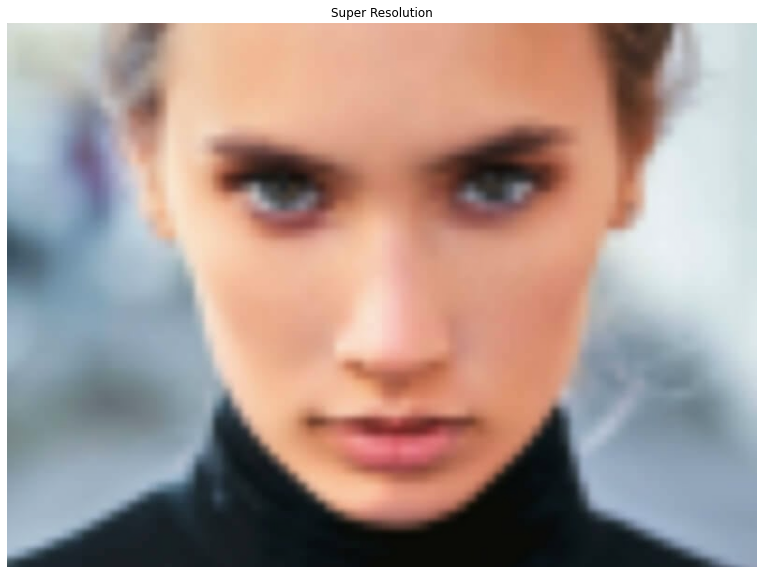

In [25]:
#plot the output image 
plot_image(tf.squeeze(super_image),'Super Resolution')

## Evalutaion 

In [26]:
IMAGE_PATH = "tiger.jpg"

In [27]:
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [28]:
hr_image = preprocess_image(IMAGE_PATH)

In [29]:
lr_image = downscale_image(tf.squeeze(hr_image))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  from ipykernel import kernelapp as app


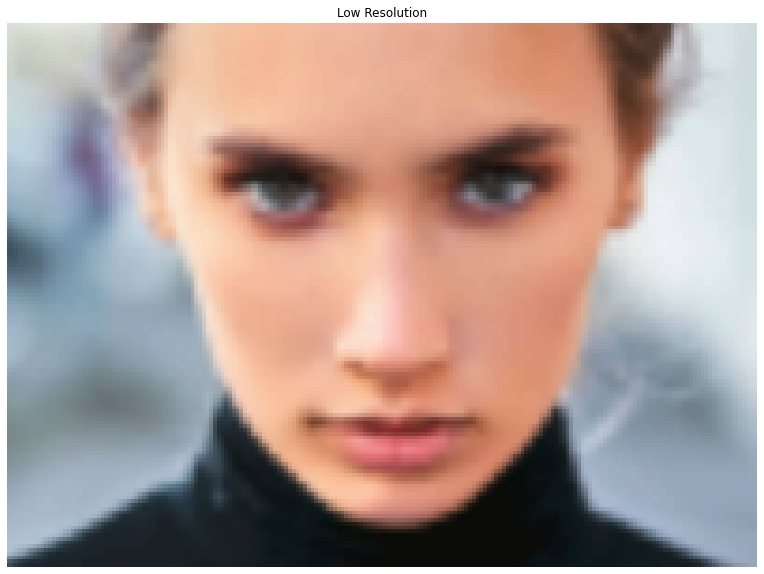

In [30]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [31]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 4.400309


PSNR Achieved: 41.647758


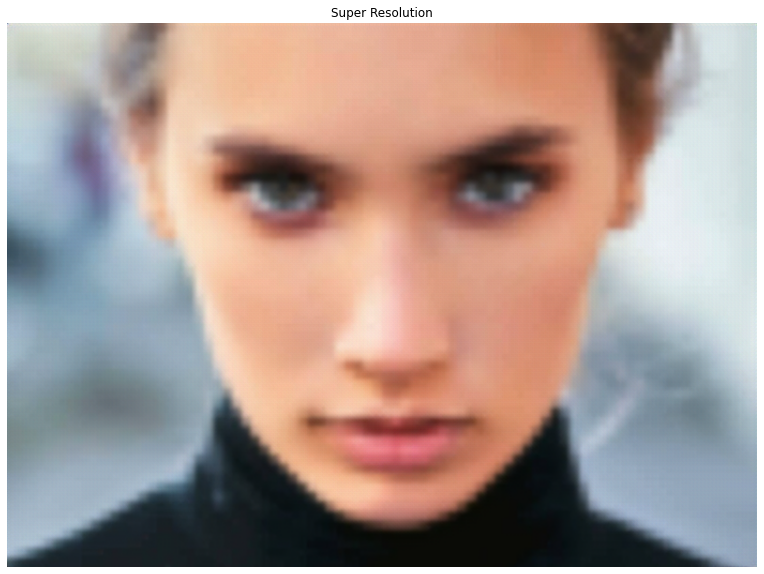

In [32]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 41.647758


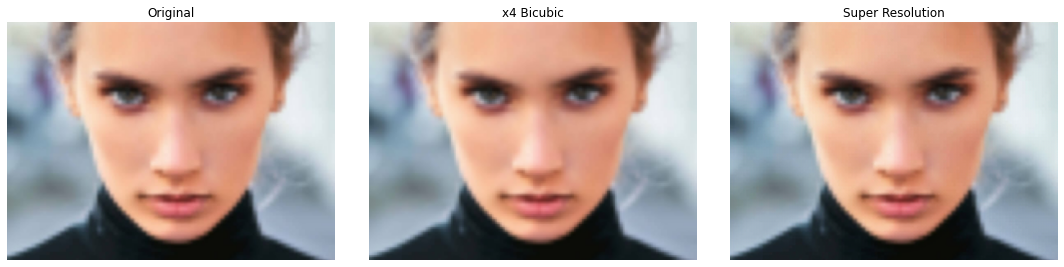

In [33]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

---